# Part 1 News articles classification

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
                        
from sklearn.externals import joblib
import pickle
import logging
import warnings 
from time import time 
import pandas as pd
import numpy as np
from collections import Counter
import time
import string
import re
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros

import gensim
from gensim.models import Word2Vec 


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords

import random
import spacy
import talos
from talos.utils import hidden_layers

from sklearn.pipeline import Pipeline



import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot



from sklearn  import preprocessing
from sklearn.model_selection   import cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics           import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing     import LabelEncoder

# Datasets exploring

Datasets loading and overview the first rows of the data

In [2]:
train_data=pd.read_csv('train.csv', header=None, na_values=None, names = ['label', 'article_title', 'article_text'])
test_data=pd.read_csv('test.csv', header=None, na_values=None, names = ['label', 'article_title', 'article_text'])

In [3]:
train_data.head(5)

,label,article_title,article_text
0,2,Wizards Guard Blake Out 10-12 Week (AP),AP - Washington Wizards point guard Steve Blak...
1,4,Brief: HP acquires Synstar for \$293M,In a move designed to help it better compete i...
2,3,US Airways #39; pilots vote for 18 salary redu...,US Airways #39; pilots voted to approve a new ...
3,4,Radiation risks 'need updating',A UK panel examining radiation risks says offi...
4,1,President's fate is on the line in Venezuela,CARACAS -- Partisans on both sides are calling...


In [4]:
test_data.head(5)

,label,article_title,article_text
0,3,Qwest: The end of the beginning,Thursday #39;s agreement between Qwest Communi...
1,1,Sadr Militiamen Still in Control of Iraq Shrine,"NAJAF, Iraq (Reuters) - Rebel Shi'ite fighter..."
2,4,Google Unveils Scholar Search Tool,"JACKSONVILLE, FL -- The online search engine l..."
3,2,Titans OT Munoz has surgery,"Knoxville, TN (Sports Network) - Tennessee Tit..."
4,4,"When outsourcing, don't forget security, exper...","When outsourcing IT operations offshore, compa..."


Checking for missing and zero values

In [5]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
label            40000 non-null int64
article_title    40000 non-null object
article_text     40000 non-null object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
label            4000 non-null int64
article_title    4000 non-null object
article_text     4000 non-null object
dtypes: int64(1), object(2)
memory usage: 93.8+ KB


In [7]:
train_data.isnull().values.any()

False

In [8]:
test_data.isnull().values.any()

False

Datasets contain no zero and missing values

Assigning appropriate column names and label mapping to the news topics

In [9]:
#Defining target variable
y_train = train_data['label']
y_test = test_data['label']

Mapping label numbers to the news topic category

In [10]:
train_data['category_name']=train_data['label'].map({1:'world', 2:'sports',3:'business', 4:'sci/tech' })
test_data['category_name']=test_data['label'].map({1:'world', 2:'sports',3:'business', 4:'sci/tech' })

Merging the news title and text columns into one to obtain more comprehensive information

In [11]:
train_data['full_text'] = train_data['article_title'] + " " + train_data['article_text']
test_data['full_text'] = test_data['article_title'] + " " + test_data['article_text']

In [12]:
train_data.head(5)

,label,article_title,article_text,category_name,full_text
0,2,Wizards Guard Blake Out 10-12 Week (AP),AP - Washington Wizards point guard Steve Blak...,sports,Wizards Guard Blake Out 10-12 Week (AP) AP - W...
1,4,Brief: HP acquires Synstar for \$293M,In a move designed to help it better compete i...,sci/tech,Brief: HP acquires Synstar for \$293M In a mov...
2,3,US Airways #39; pilots vote for 18 salary redu...,US Airways #39; pilots voted to approve a new ...,business,US Airways #39; pilots vote for 18 salary redu...
3,4,Radiation risks 'need updating',A UK panel examining radiation risks says offi...,sci/tech,Radiation risks 'need updating' A UK panel exa...
4,1,President's fate is on the line in Venezuela,CARACAS -- Partisans on both sides are calling...,world,President's fate is on the line in Venezuela C...


# Exploring the Training Dataset

Printing and visualisation the frequency distribution of the class attributes

business    10000
sci/tech    10000
world       10000
sports      10000
Name: category_name, dtype: int64


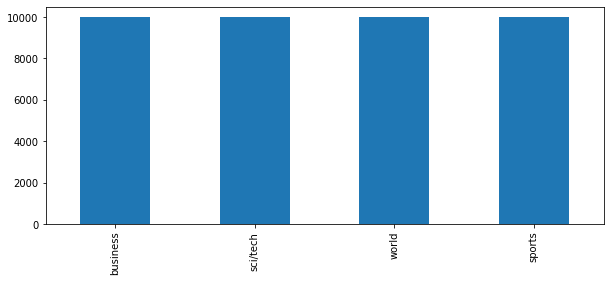

In [8]:
distr = train_data['category_name'].value_counts()
print(distr)
plt.figure(figsize=(10,4))
distr.plot(kind='bar')

The classes are very well balanced

Word counting

In [53]:
#New column with word number
train_data['word_number'] = train_data['full_text'].apply(lambda x: len(x.split(' ')))

#Number of unique words
uniq_raw = []
for sent in train_data['full_text']:
    for word in (sent.split(' ')):
        uniq_raw.append(word)

print('Total number of words in the training dataset:', train_data['word_number'].sum(),'\n')
print('Total number of unique words in the training dataset:', len(set(uniq_raw)),'\n')
print('Average number of words in the training dataset:', train_data['word_number'].mean())

Total number of words in the training dataset: 1537305 

Total number of unique words in the training dataset: 104855 

Average number of words in the training dataset: 38.432625


In [10]:
train_data['word_number'].describe()

count    40000.000000
mean        38.432625
std         10.529942
min          9.000000
25%         32.000000
50%         38.000000
75%         44.000000
max        178.000000
Name: word_number, dtype: float64

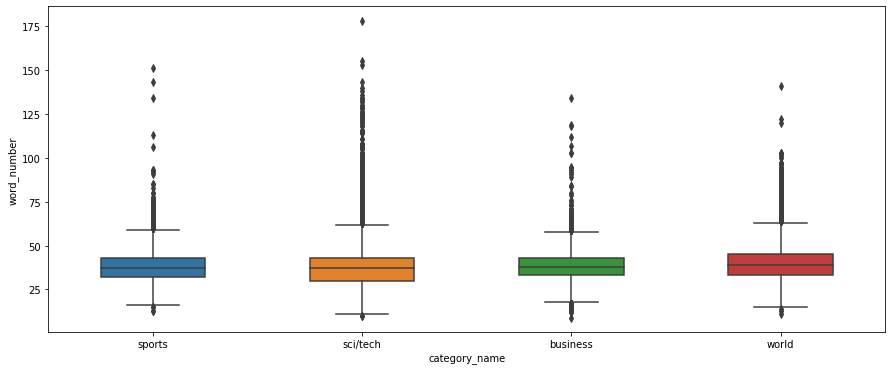

In [11]:
plt.figure(figsize=(15,6))
sns.boxplot(data=train_data, x='category_name', y='word_number', width=.5);

Document length 

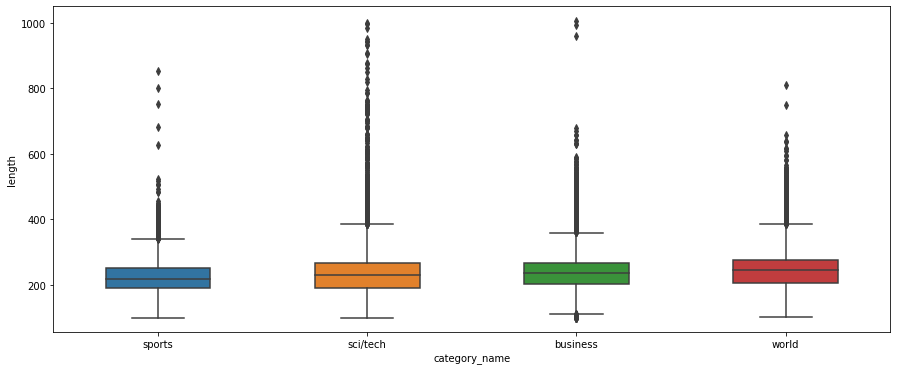

In [17]:
train_data['length'] = train_data['full_text'].str.len()
plt.figure(figsize=(15,6))
sns.boxplot(data=train_data, x='category_name', y='length', width=.5)

In [18]:
train_data['length'].describe()

count    40000.000000
mean       236.633875
std         66.501613
min        100.000000
25%        196.000000
50%        232.000000
75%        266.000000
max       1006.000000
Name: length, dtype: float64

In [19]:
train_data.head(5)

,label,article_title,article_text,category_name,full_text,word_number,length
0,2,Wizards Guard Blake Out 10-12 Week (AP),AP - Washington Wizards point guard Steve Blak...,sports,Wizards Guard Blake Out 10-12 Week (AP) AP - W...,31,170
1,4,Brief: HP acquires Synstar for \$293M,In a move designed to help it better compete i...,sci/tech,Brief: HP acquires Synstar for \$293M In a mov...,32,201
2,3,US Airways #39; pilots vote for 18 salary redu...,US Airways #39; pilots voted to approve a new ...,business,US Airways #39; pilots vote for 18 salary redu...,38,217
3,4,Radiation risks 'need updating',A UK panel examining radiation risks says offi...,sci/tech,Radiation risks 'need updating' A UK panel exa...,28,166
4,1,President's fate is on the line in Venezuela,CARACAS -- Partisans on both sides are calling...,world,President's fate is on the line in Venezuela C...,54,340


# Data Cleaning

The data pre-processing stage of the training dataset includes lowercase each word and remove punctuations, non-alphabetical symbols, stopwords and one-character words.

Function to delete URL objects

In [13]:
def remove_urls (txt):
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'target\S+', '', txt)
    txt = re.sub(r'qtype\S+', '', txt)
    txt = re.sub(r'qcat\S+', '', txt)
    return(txt)

Function to clean a text

In [14]:
def clean_doc(doc):
    tokens = doc.split()
    tokens = [word.lower() for word in tokens]
    tokens = [remove_urls(word) for word in tokens]
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]

    return " ".join(tokens)


After applying clean_doc function, cleaned text stored in the clean_data list. The total number of words significantly decrease from 1,537,305 to 982,083

In [15]:
#document loading function
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text.split('\n')

In [16]:
#loading file
#clean_data = load_doc('clean_data.txt')

In [54]:
clean_data = []
for i in range(0, len(train_data)):
    clean_t=clean_doc(train_data['full_text'][i])
    clean_data.append(clean_t)

uniq_clean =[]
for sent in clean_data:
    for word in (sent.split(' ')):
        uniq_clean.append(word)

    
print('The number of words before cleaning:', train_data['word_number'].sum(),'\n')    
print('The number of words after cleaning:', sum([len(i.split()) for i in clean_data]),'\n')
print('The number of unique words after cleaning:', len(set(uniq_clean)))  

The number of words before cleaning: 1537305 

The number of words after cleaning: 982083 

The number of unique words after cleaning: 53202


In [ ]:
# document save function
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
#saving file
#filename = 'clean_data.txt'
#save_doc(clean_data, filename)

The code below allows to compare how particular row from the text was cleaned

In [55]:
print('\033[1m'+'Text before cleaning:'+'\033[0m' +'\n', train_data['full_text'][13229], '\n')
print('\033[1m'+'Text after cleaning:'+'\033[0m'+'\n', clean_data[13229])

Text before cleaning:
 Chrysler to Build Sedans in Austria  DETROIT (Reuters) - DaimlerChrysler AG's &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=DCX.N target=/stocks/quickinfo/fullquote"&gt;DCX.N&lt;/A&gt; &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=DCXGn.DE target=/stocks/quickinfo/fullquote"&gt;DCXGn.DE&lt;/A&gt;  Chrysler division on Wednesday said it will start building its  hot-selling 300C sedan at a plant operated by Magna Steyr in  Graz, Austria, early next year. 

Text after cleaning:
 chrysler build sedans austria detroit reuters daimlerchrysler ags lta href lta href chrysler division wednesday said start building hotselling sedan plant operated magna steyr graz austria early next year


Cleaning test dataset with defined earlier clean_doc text cleaning function

In [ ]:
#loading file
#clean_test_data = load_doc('clean_test_data.txt')

In [56]:
clean_test_data = []
for i in range(0, len(test_data)):
    clean_t=clean_doc(test_data['full_text'][i])
    clean_test_data.append(clean_t)

In [33]:
#saving file
#filename = 'clean_test_data.txt'
#save_doc(clean_test_data, filename)

#  Text representation with TF-IDF

The next step is a feature engineering process, where text representation techniques such as TF-IDF and Word2vec applied to transform text data into a matrix of token counts and word embeddings. 

Term Frequency-Inverse Document Frequency (TF-IDF) is a bag-of-words technique, which converts word sequences into numerical representation – vectors.

Applying TfidfVectorizer() function with default arguments (ngram_range = (1,1), min_df =1, max_df = 1, max_features = None) on the training dataset provide with the following results:

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_data)

In [29]:
from itertools import islice

In [40]:
print('Vocabulary size:', len(vectorizer.vocabulary_))
#print('Vocabulary content:\n {}'.format(vectorizer.vocabulary_))
print('Vocabulary content:\n {}'.format(list(vectorizer.vocabulary_.items())[:10]))


Vocabulary size: 53202
Vocabulary content:
 [('wizards', 52271), ('guard', 19561), ('blake', 5070), ('week', 51560), ('ap', 2285), ('washington', 51305), ('point', 34934), ('steve', 44895), ('miss', 29130), ('first', 16574)]


Next, changing min_df and max_df parameters revealed that only the four most frequent terms (new, reuters, said, us) appear in 10% of the corpus, and therefore these parameters can remain the default values.  



In [67]:
vectorizer = TfidfVectorizer(min_df=0.1)
X = vectorizer.fit_transform(clean_data)

In [68]:
print('Vocabulary size:', len(vectorizer.vocabulary_))
vectorizer.get_feature_names()

Vocabulary size: 4


['new', 'reuter', 'said', 'us']

In [69]:
vectorizer = TfidfVectorizer(max_df=0.1)
X = vectorizer.fit_transform(clean_data)

In [41]:
print('Vocabulary size:', len(vectorizer.vocabulary_))
vectorizer.get_feature_names()[0:10]

Vocabulary size: 53202


['aa',
 'aaa',
 'aachen',
 'aal',
 'aalborg',
 'aap',
 'aapl',
 'aaplnas',
 'aaplnasdaq',
 'aaplo']

Sorting IDF scores provides with information about most and less frequent words in the corpus

In [71]:
features = np.array(vectorizer.get_feature_names())
sort_idf = np.argsort(vectorizer.idf_)
print('Features with lowest idf:', features[sort_idf[:3]]),'\n'
print('Features with highest idf:', features[sort_idf[-3:]])

Features with lowest idf: ['year' 'compani' 'ap']
Features with highest idf: ['kach' 'kahnlehmann' 'zyman']


Finally, sorting TF-IDF scores provides with weighted relevance of the words

In [72]:
sort_tfidf = X.max(axis=0).toarray().ravel().argsort()

print('Features with lowest tfidf:',features[sort_tfidf[:3]], '\n')
print('Features with highest tfidf:', features[sort_tfidf[-3:]])

Features with lowest tfidf: ['backend' 'familyth' 'granular'] 

Features with highest tfidf: ['dilithium' 'java' 'gigaset']


The next step is to train variuous machine learning algorithms with different numbers of ngram_range and max_features

# Training ML algorithms

The next step is to train machine learning algorithms such as Naïve Bayes, Linear SVM, Logistic Regression and Random Forest with different numbers of ngram_range (unigram, bigram, trigram) and max_features (7000, 15000) values.  

In [73]:
#function to display full information of tables
pd.set_option('display.max_colwidth', 0)

The list of hyperparameters to tune

In [1104]:

n_estimators = [10, 100, 200, 400]
max_features = ['auto', 'sqrt']
max_depth = [30,60,90, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['entropy', 'gini']



param = [{'vec__ngram_range': ((1, 1), (1, 2), (1,3)), 
          'vec__max_features': [7000, 15000],
          'clf'   : [LinearSVC()],
          'clf__C':[0.05, 0.1, 0.5, 1, 5, 10]
         },
         
         {'vec__ngram_range': ((1, 1), (1, 2), (1,3)), 
          'vec__max_features': [7000, 15000],
          'clf'   : [MultinomialNB()]
         },
            
         {'vec__ngram_range': ((1, 1), (1, 2), (1,3)), 
          'vec__max_features': [7000, 15000],   
         'clf': [LogisticRegression(max_iter = 7000)],
         'clf__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
         'clf__penalty' : ['l2'],
         'clf__C' : [100, 10, 1.0, 0.1, 0.01]}
        ]
         
random_grid = {'vec__ngram_range': ((1, 1), (1, 2), (1,3)), 
               'vec__max_features': (7000, 15000), 
               'r_f__n_estimators': n_estimators,
               'r_f__max_features': max_features,
               'r_f__max_depth': max_depth,
               'r_f__min_samples_split': min_samples_split,
               'r_f__min_samples_leaf': min_samples_leaf,
               'r_f__criterion': criterion
              }

Two pipeline: first for Linear SVM, Naive Bayes and Logistic Regression algorithms, second to train Random Forest algorithm

In [1094]:
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LinearSVC()),
     ])

pipe_rf = Pipeline([
    ('vec', TfidfVectorizer()),
    ('r_f',  RandomForestClassifier()),
     ])

3-fold grid and random search for selected algorithms with “accuracy” performance measure

In [1105]:
search_m = GridSearchCV(pipe, param, cv = 3, return_train_score=True, scoring = 'accuracy', n_jobs=-1)
search_m.fit(clean_data, y_train)

df_m = pd.DataFrame.from_dict(search_m.cv_results_)
df_m[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']].sort_values('rank_test_score', ascending=True)

,params,mean_test_score,mean_train_score,rank_test_score
16,"{'clf': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 0.5, 'vec__max_features': 15000, 'vec__ngram_range': (1, 2)}",0.907825,0.967550,1
17,"{'clf': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 0.5, 'vec__max_features': 15000, 'vec__ngram_range': (1, 3)}",0.907200,0.967150,2
15,"{'clf': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 0.5, 'vec__max_features': 15000, 'vec__ngram_range': (1, 1)}",0.906625,0.967262,3
82,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'vec__max_features': 15000, 'vec__ngram_range': (1, 2)}",0.906200,0.946075,4
88,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'vec__max_features': 15000, 'vec__ngram_range': (1, 2)}",0.906125,0.946075,5
11,"{'clf': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 0.1, 'vec__max_features': 15000, 'vec__ngram_range': (1, 3)}",0.906050,0.938262,6
83,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'vec__max_features': 15000, 'vec__ngram_range': (1, 3)}",0.905925,0.945913,7
89,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'vec__max_features': 15000, 'vec__ngram_range': (1, 3)}",0.905900,0.945900,8
10,"{'clf': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 0.1, 'vec__max_features': 15000, 'vec__ngram_range': (1, 2)}",0.905875,0.938737,9
81,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'vec__max_features': 15000, 'vec__ngram_range': (1, 1)}",0.905025,0.946075,10


Because of the large hyperparameter space (576 different combinations), hyperparameter tuning has been performed with the Randomised search tool

In [810]:
search_rf = RandomizedSearchCV(pipe_rf, random_grid, cv = 3, return_train_score=True, scoring = 'accuracy', n_jobs=-1)
search_rf.fit(clean_data, y_train)

df_rf = pd.DataFrame.from_dict(search_rf.cv_results_)
df_rf[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']].sort_values(by=['rank_test_score'], ascending=True)

,params,mean_test_score,mean_train_score,rank_test_score
6,"{'vec__ngram_range': (1, 2), 'vec__max_features': 15000, 'r_f__n_estimators': 400, 'r_f__min_samples_split': 10, 'r_f__min_samples_leaf': 1, 'r_f__max_features': 'auto', 'r_f__max_depth': None, 'r_f__criterion': 'gini'}",0.863800,0.997763,1
3,"{'vec__ngram_range': (1, 1), 'vec__max_features': 15000, 'r_f__n_estimators': 100, 'r_f__min_samples_split': 10, 'r_f__min_samples_leaf': 2, 'r_f__max_features': 'auto', 'r_f__max_depth': None, 'r_f__criterion': 'gini'}",0.859325,0.931350,2
7,"{'vec__ngram_range': (1, 3), 'vec__max_features': 7000, 'r_f__n_estimators': 200, 'r_f__min_samples_split': 10, 'r_f__min_samples_leaf': 2, 'r_f__max_features': 'auto', 'r_f__max_depth': None, 'r_f__criterion': 'entropy'}",0.857075,0.936613,3
9,"{'vec__ngram_range': (1, 2), 'vec__max_features': 7000, 'r_f__n_estimators': 200, 'r_f__min_samples_split': 2, 'r_f__min_samples_leaf': 1, 'r_f__max_features': 'auto', 'r_f__max_depth': None, 'r_f__criterion': 'entropy'}",0.856975,0.999913,4
5,"{'vec__ngram_range': (1, 1), 'vec__max_features': 7000, 'r_f__n_estimators': 200, 'r_f__min_samples_split': 10, 'r_f__min_samples_leaf': 1, 'r_f__max_features': 'sqrt', 'r_f__max_depth': 60, 'r_f__criterion': 'gini'}",0.837325,0.934212,5
8,"{'vec__ngram_range': (1, 2), 'vec__max_features': 15000, 'r_f__n_estimators': 10, 'r_f__min_samples_split': 2, 'r_f__min_samples_leaf': 4, 'r_f__max_features': 'sqrt', 'r_f__max_depth': None, 'r_f__criterion': 'gini'}",0.836150,0.871800,6
1,"{'vec__ngram_range': (1, 1), 'vec__max_features': 7000, 'r_f__n_estimators': 100, 'r_f__min_samples_split': 5, 'r_f__min_samples_leaf': 4, 'r_f__max_features': 'auto', 'r_f__max_depth': 90, 'r_f__criterion': 'gini'}",0.833525,0.858413,7
4,"{'vec__ngram_range': (1, 3), 'vec__max_features': 15000, 'r_f__n_estimators': 100, 'r_f__min_samples_split': 10, 'r_f__min_samples_leaf': 1, 'r_f__max_features': 'sqrt', 'r_f__max_depth': 30, 'r_f__criterion': 'gini'}",0.825000,0.873400,8
2,"{'vec__ngram_range': (1, 2), 'vec__max_features': 7000, 'r_f__n_estimators': 200, 'r_f__min_samples_split': 5, 'r_f__min_samples_leaf': 2, 'r_f__max_features': 'sqrt', 'r_f__max_depth': 30, 'r_f__criterion': 'gini'}",0.816775,0.847963,9
0,"{'vec__ngram_range': (1, 2), 'vec__max_features': 7000, 'r_f__n_estimators': 400, 'r_f__min_samples_split': 5, 'r_f__min_samples_leaf': 4, 'r_f__max_features': 'auto', 'r_f__max_depth': 30, 'r_f__criterion': 'gini'}",0.809750,0.827625,10


The highest score of about 90,8% obtained with Linear SVM algorithm, unigram and bigram sequence of words, size of vocabulary equal 15,000 and regularization hyperparameter (C) equal 0.5

Maximum validation accuracy
 
SVM: 0.9078249605107684,
Random Forest: 0.8637999829551761,
Naive Bayes: 0.8999749461263155


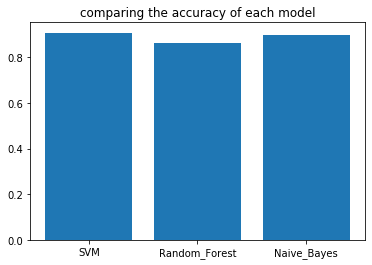

In [854]:
svm_max = search_svm.cv_results_.get('mean_test_score').max()
r_f_max = search_rf.cv_results_.get('mean_test_score').max() 
NB_max =  search_NB.cv_results_.get('mean_test_score').max()
print ('Maximum validation accuracy\n \nSVM: {},\nRandom Forest: {},\nNaive Bayes: {}'.format(svm_max, r_f_max, NB_max))


Accuracy = [svm_max, r_f_max, NB_max]
Models = ['SVM','Random_Forest','Naive_Bayes']
Accuracy_pos = np.arange(len(Models))
plt.bar(Accuracy_pos, Accuracy)
plt.xticks(Accuracy_pos, Models)
plt.title('comparing the accuracy of each model')
plt.show()

Fit and transform the training text data with obtained earlier best parameters of ngram_range and max_features

In [ ]:
#Loading vectorizer
#vectorizer = joblib.load('tfidf_vectroizer.pkl')

In [139]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = 15000)
X_train = vectorizer.fit_transform(clean_data)

In [149]:
#saving vectorizer
#joblib.dump(vectorizer, 'tfidf_vectroizer.pkl')

['tfidf_vectroizer.pkl']

Applying best value for the 'C' hyperparameter

In [143]:
best_mod_tf_idf = LinearSVC(C = 0.5)

Training time estimation for the Linear SVM algorithm 

In [144]:
%%timeit
best_mod_tf_idf.fit(X_train, y_train)

507 ms ± 53.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [145]:
#saving best model
joblib_file = "best_model_tfidf.pkl"
joblib.dump(best_mod_tf_idf, joblib_file)

['best_model_tfidf.pkl']

# Evaluation on the test dataset

Transforming the test dataset with the same TF-IDF vectorizer and applying trained earlier Linear SVM model, the accuracy score around 91% have been achieved:

In [ ]:
#Loading vectorizer
#vectorizer = joblib.load('tfidf_vectroizer.pkl')

In [183]:
X_test = vectorizer.transform(clean_test_data)

In [ ]:
#loading best model
model_tfidf = joblib.load('best_model_tfidf.pkl')

Test dataset accuracy score: 0.91275 

              precision    recall  f1-score   support

       world       0.93      0.90      0.92      1000
      sports       0.95      0.98      0.97      1000
    business       0.89      0.87      0.88      1000
    sci/tech       0.88      0.89      0.89      1000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



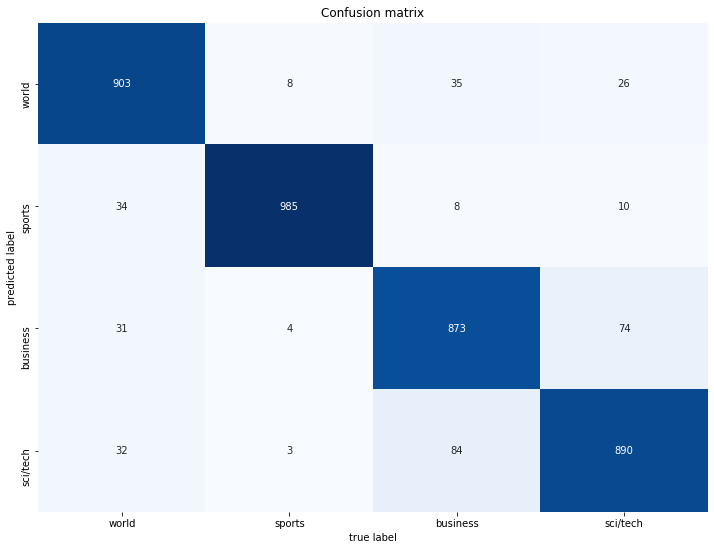

In [14]:
#Creating the list with unique category names
aux_df = test_data[['category_name', 'label']].drop_duplicates().sort_values('label')

#prediction on the cleaned test dataset
y_pred = model_tfidf.predict(X_test)

print('Test dataset accuracy score:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred, target_names=aux_df['category_name'].values))

con = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,9))
ax_cor_b = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=aux_df['category_name'].values, 
            yticklabels=aux_df['category_name'].values,
            cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()





The most accurately classified news topic is sports with f1-score equal to 0.97. More classification errors of the model occurred on the business and sci/tech topics both performing with 0.88 f1-score.

# Text Representation with Word2vec

Word2vec is a word embedding technique with the general assumption that words in the corpus share similar contexts and meaning and therefore might have similar vector representation. 

The first step is to tokenised input text and transform it to list of lists format

In [42]:
sent = [row.split() for row in clean_data]

Since the overall size of corpus is relatively small (53202 unique words) and dataset was previously cleaned from stopwords, parameters such as size = 100 (the number of transformed vector’s dimensions), window = 5 (the maximum number of surrounding words to analyze), min_count = 1 (minimum count of words to proceed) and sg =1 (Skip-gram architecture) were selected for text transformation. 

In [ ]:
#Load the Word2vec model
#model_w2v = Word2Vec.load("word2vec.model")
#model_w2v.init_sims(replace = True)

In [47]:
w_model_sg = Word2Vec(sent, size = 100, window = 5, min_count = 1, sg = 1)
w_model_sg.init_sims(replace = True)
w_model_sg.wv.vectors.shape

(53202, 100)

In [84]:
#saving model
#w_model_sg.save("word2vec.model")

In [49]:
#saving weights
filename = 'embedding_sg_word2vec.txt'
w_model_sg.wv.save_word2vec_format(filename, binary=False)

Each word in the vocabulary transformed to the 100-dimensinal vector

In [48]:
ww = dict(zip(w_model_sg.wv.index2word, w_model_sg.wv.vectors))

Expressions below demonstrate the 100-dimensional representation of the‘computer’ word and the most relevant context words estimated with cosine similarity. 

In [1422]:
    w_model_sg.wv['computer']

array([ 0.06388441, -0.08133382, -0.13676958,  0.10582004,  0.06654062,
       -0.04945404,  0.07931393,  0.08044662, -0.19894224, -0.04958534,
        0.08718207, -0.20376472, -0.02995504, -0.11479849, -0.09902271,
        0.08149272, -0.02656364, -0.00617725, -0.01187406, -0.13356061,
        0.05705734, -0.0504782 ,  0.21819203,  0.14567892,  0.11150423,
        0.22995125, -0.13097145, -0.04231865, -0.05635202,  0.01697813,
        0.09151268,  0.08142684,  0.09050979, -0.07395874,  0.02765094,
       -0.10545062, -0.07931811,  0.00223664, -0.00463745, -0.06310347,
        0.019389  ,  0.17977041,  0.17574738,  0.04723195,  0.0760856 ,
       -0.00848501,  0.12051502,  0.15135323, -0.02821335, -0.07651005,
       -0.05400637, -0.06249378, -0.03090185, -0.1311977 ,  0.13637047,
       -0.01506626, -0.06128463,  0.07527307,  0.03063625, -0.02353359,
       -0.135863  ,  0.11806294,  0.00530435, -0.06856249,  0.13208763,
        0.02626646, -0.05626931, -0.24905108, -0.03653201, -0.05

In [1420]:
w_model_sg.wv.most_similar('computer')

[('computers', 0.7709169387817383),
 ('powerbook', 0.7192236185073853),
 ('hacker', 0.7096250057220459),
 ('personal', 0.7085227966308594),
 ('ibook', 0.6991468667984009),
 ('macintosh', 0.6917257308959961),
 ('aapl', 0.6909997463226318),
 ('pc', 0.6901720762252808),
 ('cupertino', 0.6838955879211426),
 ('accessed', 0.6793504953384399)]

Furthermore, it is possible to calculate a similarity between two words 

In [119]:
w_model_sg.wv.similarity('ibm', 'computer')

0.6137135

The expression below excludes an irrelevant word from the list of three

In [120]:
w_model_sg.wv.doesnt_match(['computer', 'paris', 'berlin'])

'computer'

# Training ML algorithms

One common approach to performing classification with ML algorithms is to calculate the average feature vector for each list of words in the training dataset. 

Word averaging has been performed with defined by https://gist.github.com/susanli2016/dae5c9ff3cea5744822384881fc619dd#file-word_averaging
function, which iterates through each row of the input text, extracts 100-dimensional vectorial representation and then calculates mean value by each column (axis=0)

In [81]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [95]:
X_train_word_average_sg = word_averaging_list(w_model_sg.wv, np.array(sent))
X_train_word_average_sg.shape

(40000, 100)

After applying defined averaging function, transformed dataset with dimensions (40000,100) is ready to be processed through Linear SVM, Logistic Regression and Random Forest ML algorithms. Naïve Bayes has been excluded due to negative values in the training dataset

In [83]:
params = [{ 'clf': [LinearSVC(max_iter = 7000)],
          'clf__C':[0.5, 1, 10, 50, 100, 500]},
          
          {'clf': [LogisticRegression(max_iter = 9000)],
           'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
           'clf__C': [1, 100, 500, 800]
          }]

# RandomForest Hyperparameters
n_estimators = [100, 250, 400]
max_features = ['auto', 'sqrt']
max_depth = [30,60,90, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
criterion = ['entropy', 'gini']


r_f_par = {   'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion
           }

In [84]:
pipe2 = Pipeline([('clf', LinearSVC())])

As for TF-IDF method, Linear SVM, Logistic Regression and Random Forest algorithms were estimated and tuned through 3-fold grid and randomized search tools with ‘accuracy’ scoring.

In [98]:
search_sg = GridSearchCV(pipe2, params,cv = 3,return_train_score = True, n_jobs = -1, scoring = 'accuracy')
search_sg.fit(X_train_word_average_sg, y_train)
print(search_sg.best_params_)

{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 500, 'clf__solver': 'liblinear'}


In [107]:
df3 = pd.DataFrame.from_dict(search_sg.cv_results_)
df3[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,params,mean_test_score,mean_train_score,rank_test_score
9,"{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=9000, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 500, 'clf__solver': 'liblinear'}",0.886075,0.888675,1
3,"{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=7000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 50}",0.886000,0.888600,2
4,"{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=7000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 100}",0.885950,0.888625,3
2,"{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=7000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 10}",0.885750,0.888575,4
5,"{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=7000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 500}",0.885600,0.888475,5
12,"{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=9000, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 100, 'clf__solver': 'liblinear'}",0.885500,0.888487,6
10,"{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=9000, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 100, 'clf__solver': 'newton-cg'}",0.885500,0.888537,7
11,"{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=9000, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 100, 'clf__solver': 'lbfgs'}",0.885450,0.888562,8
7,"{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=9000, multi_class='auto', n_jobs=None, penalty='l2', random_state=None, solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'clf__C': 500, 'clf__solver': 'newton-cg'}",0.885200,0.888537,9
1,"{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=7000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0), 'clf__C': 1}",0.885200,0.887712,10


In [179]:
r_f_clf = RandomForestClassifier()
r_f2 = RandomizedSearchCV(r_f_clf, r_f_par, cv = 3, return_train_score = True, n_jobs = -1, scoring = 'accuracy')
r_f2.fit(X_train_word_average_sg,y_train)
print(r_f2.best_params_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}


In [202]:
df7 = pd.DataFrame.from_dict(r_f2.cv_results_)
df7[['params', 'mean_test_score', 'mean_train_score','mean_fit_time', 'rank_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,params,mean_test_score,mean_train_score,mean_fit_time,rank_test_score
2,"{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}",0.890225,0.999400,210.500233,1
7,"{'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy'}",0.889525,0.998237,150.769254,2
5,"{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}",0.889250,0.995250,221.109260,3
3,"{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'entropy'}",0.889025,0.977188,146.604610,4
0,"{'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}",0.888850,0.990925,119.318242,5
9,"{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}",0.888275,0.963050,134.553910,6
8,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'criterion': 'gini'}",0.888100,0.981900,54.498798,7
4,"{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}",0.887075,0.962150,49.541311,8
1,"{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy'}",0.886325,0.967188,54.791506,9
6,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}",0.885550,0.962475,51.079988,10


Although the highest score of about 88,8% achieved with Random Forest algorithm, this model has been overfitted with accuracy 99,99% on the training dataset. 
Thus, Logistic regression algorithm with accuracy scores 88,6% on validation and 88,8% on training datasets was selected as the best model.

In [102]:
best_lr = search_sg.best_estimator_

In [150]:
start = time.time()

best_lr.fit(X_train_word_average_sg,y_train)

elapsed = time.time() - start
print('\n Completed training in {} seconds.'.format(elapsed),end='\n\n')


 Completed training in 8.134909868240356 seconds.



Saving the best-performed model to the pkl-format file

In [103]:
joblib_file = "best_w2v.pkl"
joblib.dump(best_lr, joblib_file)

['best_w2v.pkl']

# Evaluation on the test dataset

Transforming cleaned test dataset to the list of lists format

In [ ]:
#load cleaned test data
clean_test_data = load_doc('clean_test_data.txt')

In [87]:
test_sent = [row.split() for row in clean_test_data]

Word averaging with devined earlier function

In [91]:
X_test_word_average_sg = word_averaging_list(w_model_sg.wv,np.array(test_sent))

Applying Logistic Regression algorithm with the best tuned hyperparameters on the test dataset, the accuracy score 88,7% has been achieved. 

The best result has been achieved by sports news topic with 967 from 1000 correctly classified articles. The most classification errors (160) have been generated by Business topic.

In [ ]:
# Load the best model
best_lr = joblib.load("best_w2v.pkl")

Test dataset accuracy score: 0.887 

              precision    recall  f1-score   support

       world       0.91      0.89      0.90      1000
      sports       0.94      0.97      0.95      1000
    business       0.85      0.84      0.84      1000
    sci/tech       0.85      0.85      0.85      1000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



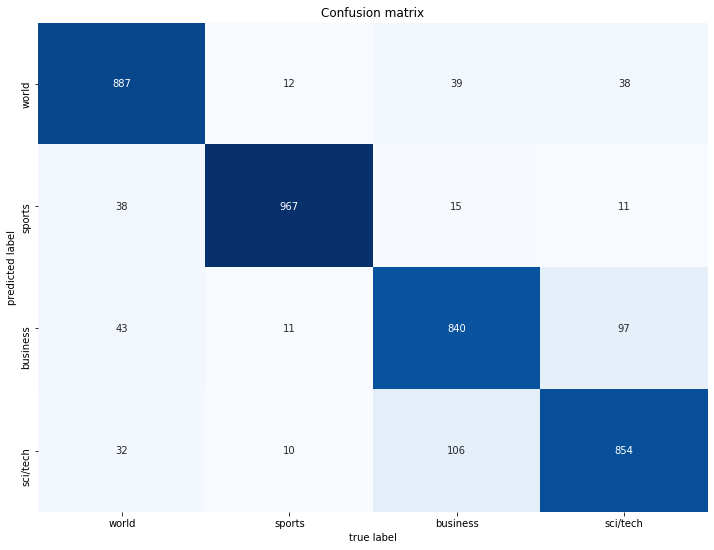

In [108]:
#Creating the list with unique category names
aux_df = test_data[['category_name', 'label']].drop_duplicates().sort_values('label')

#prediction on the cleaned test dataset
y_pred = best_lr.predict(X_test_word_average_sg)

print('Test dataset accuracy score:', accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred, target_names=aux_df['category_name'].values))

con = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,9))
ax_cor_b = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=aux_df['category_name'].values, 
            yticklabels=aux_df['category_name'].values,
            cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()

# Deep Learning Model

In [50]:
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, GRU, TimeDistributed, Bidirectional, GlobalMaxPooling1D

from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D

The first step to develop a Deep Learning (DL) model is to import a 100-dimensional vector with 53,202 unique words Word2vec model, pre-trained in the previous section. The function below imports pre-trained model and returns words inside the dictionary.                  
The function build by https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [17]:
# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

In [18]:
imported_vocab = load_embedding('embedding_sg_word2vec.txt')

The next step is to encode the training data by assigning integer number to each unique word and then convert each row of the source text to sequences of corresponding integers. Encoding has been performed with Keras Tokenizer tool

In [29]:
#Load files and Tokenizer
#clean_data = load_doc('clean_data.txt')
#clean_test_data = load_doc('clean_test_data.txt')
#tokenizer1 = joblib.load('C_LSTM_tokenizer.pkl')

In [57]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(clean_data)

encoded_docs_tr = tokenizer1.texts_to_sequences(clean_data)
encoded_docs_te = tokenizer1.texts_to_sequences(clean_test_data)

In [41]:
#saving Tokenizer
#joblib.dump(tokenizer1, 'C_LSTM_tokenizer.pkl')

['CNN_tokenizer.pkl']

Calling word_index attribute demonstrates how each unique word has been encoded with integer numbers

In [62]:
list(tokenizer1.word_index.items())[0:10]

[('new', 1),
 ('said', 2),
 ('us', 3),
 ('reuters', 4),
 ('ap', 5),
 ('first', 6),
 ('two', 7),
 ('world', 8),
 ('thursday', 9),
 ('oil', 10)]

One of the dimensions of the Keras embedding layer is the vocabulary size. This number equal to the number of unique words + 1 (because of Keras indexing from zero) is 53203

In [21]:
vocab_size = len(tokenizer1.word_index) + 1
vocab_size

53203

Keras embedding layer has been built by mapping encoded integers to the vocabulary with pre-trained weights. The mapping process has been performed with get_weight_matrix function, where weight matrix with dimensions (53203, 100) mapped pre-trained weights with integer numbers.

The function build by https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [22]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

In [23]:
embedding_vectors = get_weight_matrix(imported_vocab, tokenizer1.word_index)

Finally, training and testing datasets with appropriate to Keras format might be created with a defined earlier encoded-word dictionary. One of the Keras requirement is that input data should be a vector in the same length, therefore training and testing datasets zero-padded to 90 (maximum length of the vector in the training dataset)

In [24]:
max_length = max([len(s.split()) for s in clean_data])
max_length

90

In [25]:
Xtrain = pad_sequences(encoded_docs_tr, maxlen=max_length, padding='post')
Xtest = pad_sequences(encoded_docs_te, maxlen=max_length, padding='post')

In [26]:
Xtrain.shape

(40000, 90)

Class attributes on both train and test datasets should be one-hot encoded

In [27]:
#load label encoder
#le = joblib.load('label_encoder.pkl')

In [28]:
le = preprocessing.LabelEncoder()
train_data['labeling'] = le.fit_transform(train_data['label'])
test_data['labeling'] = le.transform(test_data['label'])
num_classes = np.max(train_data['labeling']) + 1

In [29]:
#saving label encoder
#joblib.dump(le, 'label_encoder.pkl')

In [30]:
ytrain = keras.utils.to_categorical(train_data['labeling'],num_classes)
ytest = keras.utils.to_categorical(test_data['labeling'],num_classes)

In the present work, news articles classification task was performed with C-LSTM Neural Network model, which consists of both CNN and LSTM layers. 


The following parameters were applied to train C-LSTM model: 
“categorical_crossentropy” loss function – because of multiclass nature of the classification task and the one-hot representation of the labels. 
"softmax" output activation function, as it accommodates multiple classes into the normalized probabilistic vector with the total sum one.
“accuracy” performance measure, since classes in the dataset well balanced.
“batch_size” equal to 128, in order to increase the training speed of the model.

Another hyperparameters such as filters number, kernel size, dropout rate, optimizer, activation function and the number of hidden layers were tuned with Talos library https://autonomio.github.io/talos/#/

First step is define the function that builds, compiles and fits the Keras model

In [31]:
def clf_model(x_train, y_train, x_val, y_val, params):
    model_CNN6 = Sequential()
    model_CNN6.add(Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False))
    model_CNN6.add(Dropout(0.3))
    model_CNN6.add(Conv1D(filters=params['filters'], kernel_size = params['kernel_size'], activation='relu'))
    model_CNN6.add(MaxPooling1D(pool_size=2))
    model_CNN6.add(Dropout(0.3))
    model_CNN6.add(LSTM(64, recurrent_dropout=0.15))
    model_CNN6.add(Dropout(0.3))
    model_CNN6.add(Dense(16, activation='relu'))


    model_CNN6.add(Dense(4, activation='softmax'))
    
    model_CNN6.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])

    history = model_CNN6.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=128,
                        callbacks=[talos.utils.live()],
                        epochs=10,
                        verbose=0)

    return history, model_CNN6

Hyperparameter space

In [32]:
p = {'filters': [64, 128, 256],
     'kernel_size': [4, 5, 8],
     'optimizer': ['Nadam', 'Adam']
    }

After defining the function and hyperparameters space, Talos might be initiated with Scan command

20% of the training dataset was selected for validation

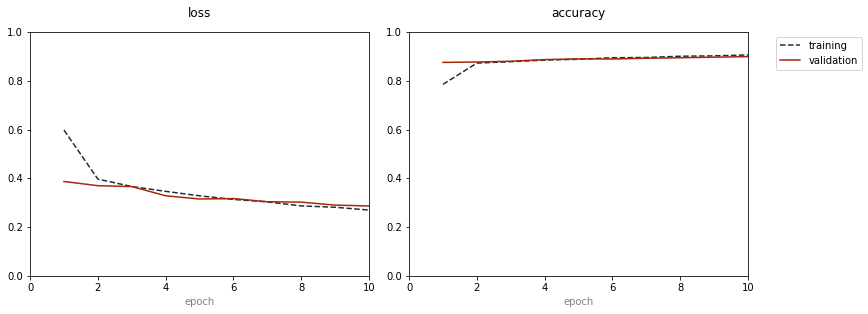

100%|██████████| 18/18 [3:35:22<00:00, 822.24s/it]


In [33]:
exp8 = talos.Scan(x=Xtrain,
               y=ytrain,
               val_split = 0.2,
               model=clf_model,
               params=p,
               experiment_name='clf8',
               seed = 44,
               round_limit = 18
                 )

In [34]:
exp8.data.head(18).sort_values(by=['val_accuracy'], ascending=False)

,round_epochs,val_loss,val_accuracy,loss,accuracy,filters,kernel_size,optimizer
17,10,0.286478,0.899000,0.269526,0.905781,256,8,Nadam
16,10,0.298538,0.895625,0.296623,0.900719,256,4,Nadam
2,10,0.290606,0.895500,0.280066,0.903188,128,8,Nadam
10,10,0.300019,0.895500,0.288677,0.902344,256,8,Adam
14,10,0.293536,0.894750,0.284947,0.902594,256,5,Nadam
8,10,0.308003,0.893750,0.311851,0.894781,128,8,Adam
4,10,0.315393,0.893375,0.309617,0.895094,128,5,Nadam
7,10,0.304281,0.893000,0.310762,0.895063,256,4,Adam
12,10,0.318829,0.891125,0.326161,0.890063,128,5,Adam
3,10,0.307992,0.891125,0.310003,0.896031,256,5,Adam


The best combinations of hyperparameters provided by round 14, with validation accuracy equal about 97,7 %. 

A four-dimensional bar grid for visualizing hyperparameters relationships

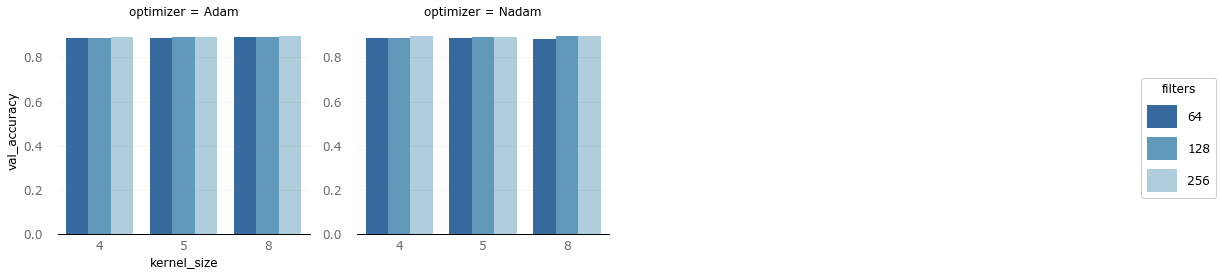

In [37]:
analyze_object = talos.Analyze(exp8)
analyze_object.plot_bars('kernel_size', 'val_accuracy', 'filters','optimizer')

In [39]:
#saving talos results
talos.Deploy(exp8, 'clf9', metric = 'val_accuracy')

Deploy package clf9 have been saved.


In [ ]:
#restore talos results
talos.Restore('clf9')

According to Talos results, the best combinations of hyperparameters represented with Nadam optimizer, 256 filters and 8 kernel size with validation accuracy 89,90 %. Next, C-LSTM model was trained with selected best hyperparameters (except kernel size, which was checked by trial and error approach), 26 epochs and batch size equal to 128 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 90, 100)           5320300   
_________________________________________________________________
dropout_42 (Dropout)         (None, 90, 100)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 86, 256)           128256    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 43, 256)           0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 43, 256)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                82176     
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)              

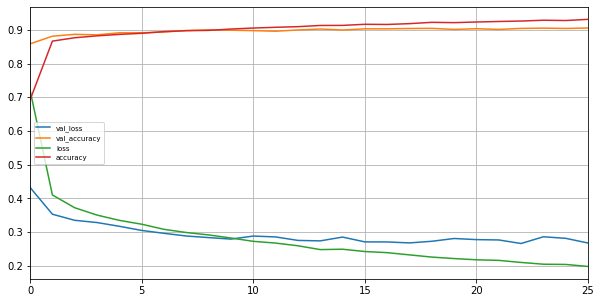

In [48]:
random.seed(93)

model_CNN5 = Sequential()
model_CNN5.add(Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False))

model_CNN5.add(Dropout(0.3))
model_CNN5.add(Conv1D(filters=256, kernel_size = 5, activation='relu'))
model_CNN5.add(MaxPooling1D(pool_size=2))
model_CNN5.add(Dropout(0.3))

model_CNN5.add(LSTM(64,recurrent_dropout=0.15))

model_CNN5.add(Dropout(0.3))

model_CNN5.add(Dense(16, activation='relu'))

model_CNN5.add(Dense(num_classes, activation='softmax'))

print(model_CNN5.summary())


# compile network
model_CNN5.compile(loss = 'categorical_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

start = time.time()
# fit network
history = model_CNN5.fit(Xtrain, ytrain, epochs = 26, batch_size = 128, verbose=1, validation_split = 0.2)


pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.legend(loc=6, prop={'size': 7})
plt.grid(True)

elapsed = time.time() - start
print('\n Completed training in {} seconds.'.format(elapsed),end='\n\n')

In [ ]:
#loading the model
#model_CNN5 = keras.models.load_model('model_CNN8.h5')

Finally, applying the trained model on the test dataset, the accuracy score 91.47% has been achieved

In [49]:
# evaluate the model
loss, acc = model_CNN5.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))    

Test Accuracy: 91.474998


In [50]:
#saving the model
#model_CNN5.save('model_CNN8.h5')